In [17]:
!curl -L -o dataset.csv "https://raw.githubusercontent.com/Juan-Herrera-Silva/Paper-SENSORS/refs/heads/main/Annex%20A%20-%20Dataset%20with%2050%20chosen%20features.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  224k  100  224k    0     0   857k      0 --:--:-- --:--:-- --:--:--  862k


# Importando bibliotecas necessárias

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Carregando e explorando o dataset

In [19]:
df = pd.read_csv('dataset.csv')

print("Shape do dataset:", df.shape)
print("\nPrimeiras 5 linhas:")
print(df.head())
print("\nInformações sobre o dataset:")
print(df.info())
print("\nValores nulos:")
print(df.isnull().sum().sum())

Shape do dataset: (2000, 51)

Primeiras 5 linhas:
  family  proc_pid  file  urls  type  name  ext_urls  path  program  info  \
0      E         0     0     0     0     0         0     0        0     0   
1      G         0     0     0     0     0         0     0        0     0   
2      E         1     1     0     0     0         0     0        0     0   
3      L         0     0     0     0     0         0     0        0     0   
4      G         0     0     0     0     0         0     0        0     0   

   ...  regkey_opened  file_created  wmi_query  dll_loaded  regkey_written  \
0  ...              0             0          0           0               0   
1  ...              0             0          0           0               0   
2  ...              0             0          0           0               0   
3  ...              0             1          0           7               0   
4  ...             27             0          0           6               0   

   file_read  apis

# Identificando a variável target e features

In [20]:
print("Colunas do dataset:")
print(df.columns.tolist())
print("\nDistribuição da primeira coluna (target):")
print(df.iloc[:, 0].value_counts())

target_column = df.columns[0]
print(f"\nColuna target identificada: {target_column}")

X = df.drop(columns=[target_column])
y = df[target_column]

print(f"\nShape de X (features): {X.shape}")
print(f"Shape de y (target): {y.shape}")
print(f"Classes únicas no target: {y.unique()}")

Colunas do dataset:
['family', 'proc_pid', 'file', 'urls', 'type', 'name', 'ext_urls', 'path', 'program', 'info', 'positives', 'families', 'description', 'sign_name', 'sign_stacktrace', 'arguments', 'api', 'category', 'imported_dll_count', 'dll', 'pe_res_name', 'filetype', 'pe_sec_name', 'entropy', 'hosts', 'requests', 'mitm', 'domains', 'dns_servers', 'tcp', 'udp', 'dead_hosts', 'proc', 'beh_command_line', 'process_path', 'tree_command_line', 'children', 'tree_process_name', 'command_line', 'regkey_read', 'directory_enumerated', 'regkey_opened', 'file_created', 'wmi_query', 'dll_loaded', 'regkey_written', 'file_read', 'apistats', 'errors', 'action', 'log']

Distribuição da primeira coluna (target):
family
G    1000
E     800
L     200
Name: count, dtype: int64

Coluna target identificada: family

Shape de X (features): (2000, 50)
Shape de y (target): (2000,)
Classes únicas no target: ['E' 'G' 'L']


# Pré-processamento dos dados

In [21]:
if not pd.api.types.is_numeric_dtype(y):
    print(f"Convertendo target não numérico para numérico...")
    le = LabelEncoder()
    y = le.fit_transform(y)
    print(f"Classes após conversão: {np.unique(y)}")

categorical_features = X.select_dtypes(include=['object']).columns
if len(categorical_features) > 0:
    print(f"Convertendo features categóricas: {categorical_features.tolist()}")
    for col in categorical_features:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("Pré-processamento concluído!")
print(f"Shape final de X: {X_scaled.shape}")
print(f"Shape final de y: {y.shape}")

Convertendo target não numérico para numérico...
Classes após conversão: [0 1 2]
Pré-processamento concluído!
Shape final de X: (2000, 50)
Shape final de y: (2000,)


# Função para calcular todas as métricas

In [22]:
def calculate_metrics(y_true, y_pred, model_name="Modelo"):
    """
    Calcula e exibe todas as métricas solicitadas
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"\n--- Métricas para {model_name} ---")
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precisão: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# Divisão dos dados: 60% treino, 20% validação, 20% teste

In [23]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 * 0.8 = 0.2
)

print(f"Dataset dividido em:")
print(f"Treino: {X_train.shape[0]} amostras ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Validação: {X_val.shape[0]} amostras ({X_val.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Teste: {X_test.shape[0]} amostras ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")

Dataset dividido em:
Treino: 1200 amostras (60.0%)
Validação: 400 amostras (20.0%)
Teste: 400 amostras (20.0%)


# Implementação do K-Fold Cross Validation (k=5)

In [ ]:
def evaluate_with_kfold(model, X_data, y_data, k=5, model_name="Modelo"):
    """
    Avalia um modelo usando K-Fold Cross Validation
    """
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    
    print(f"\n=== Avaliação K-Fold para {model_name} (k={k}) ===")
    
    for fold, (train_idx, test_idx) in enumerate(kfold.split(X_data), 1):
        X_fold_train, X_fold_test = X_data.iloc[train_idx], X_data.iloc[test_idx]
        y_fold_train, y_fold_test = y_data[train_idx], y_data[test_idx]
        
        model_copy = type(model)(**model.get_params()) if hasattr(model, 'get_params') else type(model)()
        model_copy.fit(X_fold_train, y_fold_train)
        
        y_pred = model_copy.predict(X_fold_test)
        
        accuracy = accuracy_score(y_fold_test, y_pred)
        precision = precision_score(y_fold_test, y_pred, average='weighted')
        recall = recall_score(y_fold_test, y_pred, average='weighted')
        f1 = f1_score(y_fold_test, y_pred, average='weighted')
        
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
        print(f"Fold {fold}: Acurácia={accuracy:.4f}, Precisão={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
    
    print(f"\n--- Resultados Finais K-Fold {model_name} ---")
    print(f"Acurácia: {np.mean(accuracies):.4f} (±{np.std(accuracies):.4f})")
    print(f"Precisão: {np.mean(precisions):.4f} (±{np.std(precisions):.4f})")
    print(f"Recall: {np.mean(recalls):.4f} (±{np.std(recalls):.4f})")
    print(f"F1-Score: {np.mean(f1_scores):.4f} (±{np.std(f1_scores):.4f})")
    
    return {
        'accuracies': accuracies,
        'precisions': precisions,
        'recalls': recalls,
        'f1_scores': f1_scores,
        'mean_accuracy': np.mean(accuracies),
        'std_accuracy': np.std(accuracies),
        'mean_precision': np.mean(precisions),
        'std_precision': np.std(precisions),
        'mean_recall': np.mean(recalls),
        'std_recall': np.std(recalls),
        'mean_f1': np.mean(f1_scores),
        'std_f1': np.std(f1_scores)
    }

# 1. NAIVE BAYES

In [25]:
print("=" * 50)
print("1. TREINANDO NAIVE BAYES")
print("=" * 50)

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

nb_val_pred = nb_model.predict(X_val)
nb_val_metrics = calculate_metrics(y_val, nb_val_pred, "Naive Bayes (Validação)")

nb_test_pred = nb_model.predict(X_test)
nb_test_metrics = calculate_metrics(y_test, nb_test_pred, "Naive Bayes (Teste)")

print("\n--- Relatório de Classificação Naive Bayes (Teste) ---")
print(classification_report(y_test, nb_test_pred))

1. TREINANDO NAIVE BAYES

--- Métricas para Naive Bayes (Validação) ---
Acurácia: 0.7525
Precisão: 0.7971
Recall: 0.7525
F1-Score: 0.7373

--- Métricas para Naive Bayes (Teste) ---
Acurácia: 0.7425
Precisão: 0.7818
Recall: 0.7425
F1-Score: 0.7249

--- Relatório de Classificação Naive Bayes (Teste) ---
              precision    recall  f1-score   support

           0       0.96      0.55      0.70       160
           1       0.69      0.98      0.81       200
           2       0.54      0.33      0.41        40

    accuracy                           0.74       400
   macro avg       0.73      0.62      0.64       400
weighted avg       0.78      0.74      0.72       400



# K-Fold Cross Validation para Naive Bayes

In [26]:
nb_kfold_results = evaluate_with_kfold(nb_model, X_train, y_train, k=5, model_name="Naive Bayes")


=== Avaliação K-Fold para Naive Bayes (k=5) ===
Fold 1: Acurácia=0.7500, Precisão=0.7980, Recall=0.7500, F1=0.7365
Fold 2: Acurácia=0.7167, Precisão=0.7441, Recall=0.7167, F1=0.7038
Fold 3: Acurácia=0.7375, Precisão=0.7755, Recall=0.7375, F1=0.7210
Fold 4: Acurácia=0.7708, Precisão=0.8041, Recall=0.7708, F1=0.7568
Fold 5: Acurácia=0.7208, Precisão=0.7604, Recall=0.7208, F1=0.6999

--- Resultados Finais K-Fold Naive Bayes ---
Acurácia: 0.7392 (±0.0198)
Precisão: 0.7764 (±0.0225)
Recall: 0.7392 (±0.0198)
F1-Score: 0.7236 (±0.0211)


# 2. KNN

In [27]:
print("\n" + "=" * 50)
print("2. TREINANDO KNN")
print("=" * 50)

best_k = 3
best_score = 0
k_range = range(1, 21, 2)

print("Testando diferentes valores de k:")
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    val_pred = knn.predict(X_val)
    score = accuracy_score(y_val, val_pred)
    print(f"k={k}: Acurácia na validação = {score:.4f}")
    
    if score > best_score:
        best_score = score
        best_k = k

print(f"\nMelhor k encontrado: {best_k} com acurácia de {best_score:.4f}")

knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)

knn_val_pred = knn_model.predict(X_val)
knn_val_metrics = calculate_metrics(y_val, knn_val_pred, "KNN (Validação)")

knn_test_pred = knn_model.predict(X_test)
knn_test_metrics = calculate_metrics(y_test, knn_test_pred, "KNN (Teste)")

print("\n--- Relatório de Classificação KNN (Teste) ---")
print(classification_report(y_test, knn_test_pred))


2. TREINANDO KNN
Testando diferentes valores de k:
k=1: Acurácia na validação = 1.0000
k=3: Acurácia na validação = 1.0000
k=5: Acurácia na validação = 1.0000
k=7: Acurácia na validação = 0.9975
k=9: Acurácia na validação = 0.9850
k=11: Acurácia na validação = 0.9800
k=13: Acurácia na validação = 0.9800
k=15: Acurácia na validação = 0.9850
k=17: Acurácia na validação = 0.9825
k=19: Acurácia na validação = 0.9725

Melhor k encontrado: 1 com acurácia de 1.0000

--- Métricas para KNN (Validação) ---
Acurácia: 1.0000
Precisão: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- Métricas para KNN (Teste) ---
Acurácia: 0.9975
Precisão: 0.9976
Recall: 0.9975
F1-Score: 0.9975

--- Relatório de Classificação KNN (Teste) ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       160
           1       1.00      1.00      1.00       200
           2       0.98      1.00      0.99        40

    accuracy                           1.00       400
   macro a

# K-Fold Cross Validation para KNN

In [28]:
knn_kfold_results = evaluate_with_kfold(knn_model, X_train, y_train, k=5, model_name="KNN")


=== Avaliação K-Fold para KNN (k=5) ===
Fold 1: Acurácia=0.9875, Precisão=0.9884, Recall=0.9875, F1=0.9877
Fold 2: Acurácia=1.0000, Precisão=1.0000, Recall=1.0000, F1=1.0000
Fold 3: Acurácia=0.9917, Precisão=0.9918, Recall=0.9917, F1=0.9917
Fold 4: Acurácia=1.0000, Precisão=1.0000, Recall=1.0000, F1=1.0000
Fold 5: Acurácia=0.9917, Precisão=0.9917, Recall=0.9917, F1=0.9917

--- Resultados Finais K-Fold KNN ---
Acurácia: 0.9942 (±0.0050)
Precisão: 0.9944 (±0.0048)
Recall: 0.9942 (±0.0050)
F1-Score: 0.9942 (±0.0049)


# Comparação dos resultados

In [29]:
print("\n" + "=" * 60)
print("COMPARAÇÃO FINAL DOS MODELOS")
print("=" * 60)

comparison_data = {
    'Modelo': ['Naive Bayes', 'KNN'],
    'Acurácia (Teste)': [nb_test_metrics['accuracy'], knn_test_metrics['accuracy']],
    'Precisão (Teste)': [nb_test_metrics['precision'], knn_test_metrics['precision']],
    'Recall (Teste)': [nb_test_metrics['recall'], knn_test_metrics['recall']],
    'F1-Score (Teste)': [nb_test_metrics['f1_score'], knn_test_metrics['f1_score']],
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False, float_format='%.4f'))

if nb_test_metrics['f1_score'] > knn_test_metrics['f1_score']:
    best_model = "Naive Bayes"
    best_f1 = nb_test_metrics['f1_score']
else:
    best_model = "KNN"
    best_f1 = knn_test_metrics['f1_score']

print(f"\nMelhor modelo: {best_model} (F1-Score: {best_f1:.4f})")


COMPARAÇÃO FINAL DOS MODELOS
     Modelo  Acurácia (Teste)  Precisão (Teste)  Recall (Teste)  F1-Score (Teste)
Naive Bayes            0.7425            0.7818          0.7425            0.7249
        KNN            0.9975            0.9976          0.9975            0.9975

Melhor modelo: KNN (F1-Score: 0.9975)


# Visualizações

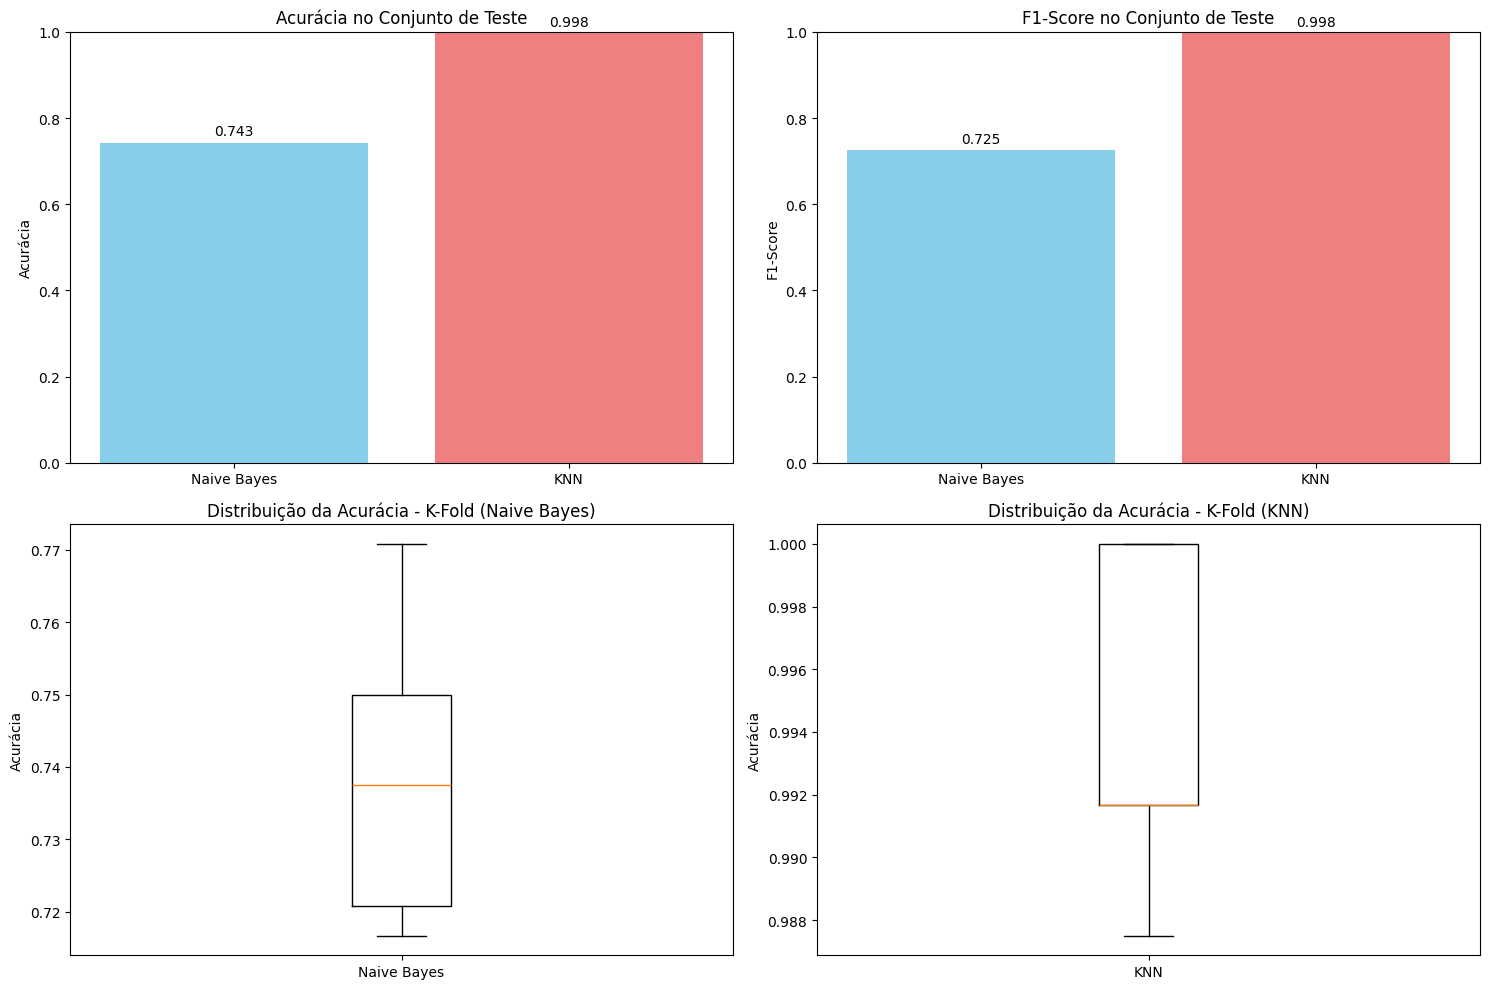

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

models = ['Naive Bayes', 'KNN']
test_accuracies = [nb_test_metrics['accuracy'], knn_test_metrics['accuracy']]
axes[0, 0].bar(models, test_accuracies, color=['skyblue', 'lightcoral'])
axes[0, 0].set_title('Acurácia no Conjunto de Teste')
axes[0, 0].set_ylabel('Acurácia')
axes[0, 0].set_ylim([0, 1])
for i, v in enumerate(test_accuracies):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

test_f1_scores = [nb_test_metrics['f1_score'], knn_test_metrics['f1_score']]
axes[0, 1].bar(models, test_f1_scores, color=['skyblue', 'lightcoral'])
axes[0, 1].set_title('F1-Score no Conjunto de Teste')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_ylim([0, 1])
for i, v in enumerate(test_f1_scores):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

axes[1, 0].boxplot([nb_kfold_results['accuracies']], labels=['Naive Bayes'])
axes[1, 0].set_title('Distribuição da Acurácia - K-Fold (Naive Bayes)')
axes[1, 0].set_ylabel('Acurácia')

axes[1, 1].boxplot([knn_kfold_results['accuracies']], labels=['KNN'])
axes[1, 1].set_title('Distribuição da Acurácia - K-Fold (KNN)')
axes[1, 1].set_ylabel('Acurácia')

plt.tight_layout()
plt.show()

# Matriz de Confusão

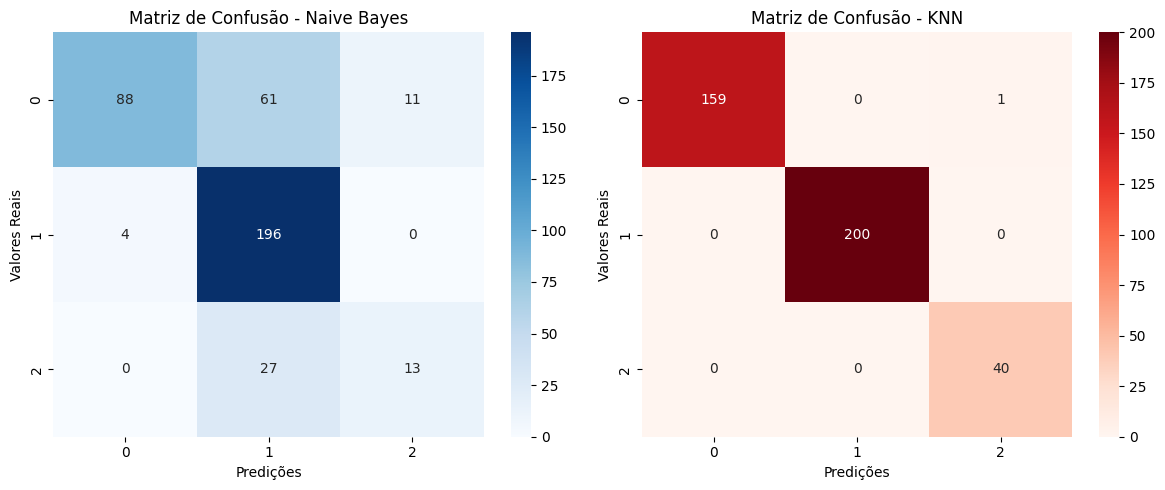

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_nb = confusion_matrix(y_test, nb_test_pred)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Matriz de Confusão - Naive Bayes')
axes[0].set_xlabel('Predições')
axes[0].set_ylabel('Valores Reais')

cm_knn = confusion_matrix(y_test, knn_test_pred)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Reds', ax=axes[1])
axes[1].set_title('Matriz de Confusão - KNN')
axes[1].set_xlabel('Predições')
axes[1].set_ylabel('Valores Reais')

plt.tight_layout()
plt.show()

# Resumo final

In [32]:
print("\n" + "=" * 80)
print("RESUMO FINAL DO EXPERIMENTO")
print("=" * 80)

print(f"""
CONFIGURAÇÃO DO EXPERIMENTO:
- Dataset: {df.shape[0]} amostras, {df.shape[1]-1} features
- Divisão: 60% treino ({X_train.shape[0]} amostras), 20% validação ({X_val.shape[0]} amostras), 20% teste ({X_test.shape[0]} amostras)
- K-Fold: 5 folds
- Algoritmos: Naive Bayes e KNN

RESULTADOS PRINCIPAIS:
""")

print("NAIVE BAYES:")
print(f"  • Acurácia (teste): {nb_test_metrics['accuracy']:.4f}")
print(f"  • Precisão (teste): {nb_test_metrics['precision']:.4f}")
print(f"  • Recall (teste): {nb_test_metrics['recall']:.4f}")
print(f"  • F1-Score (teste): {nb_test_metrics['f1_score']:.4f}")

print(f"\nKNN (k={best_k}):")
print(f"  • Acurácia (teste): {knn_test_metrics['accuracy']:.4f}")
print(f"  • Precisão (teste): {knn_test_metrics['precision']:.4f}")
print(f"  • Recall (teste): {knn_test_metrics['recall']:.4f}")
print(f"  • F1-Score (teste): {knn_test_metrics['f1_score']:.4f}")

print(f"\nMELHOR MODELO: {best_model}")
print("=" * 80)


RESUMO FINAL DO EXPERIMENTO

CONFIGURAÇÃO DO EXPERIMENTO:
- Dataset: 2000 amostras, 50 features
- Divisão: 60% treino (1200 amostras), 20% validação (400 amostras), 20% teste (400 amostras)
- K-Fold: 5 folds
- Algoritmos: Naive Bayes e KNN

RESULTADOS PRINCIPAIS:

NAIVE BAYES:
  • Acurácia (teste): 0.7425
  • Precisão (teste): 0.7818
  • Recall (teste): 0.7425
  • F1-Score (teste): 0.7249

KNN (k=1):
  • Acurácia (teste): 0.9975
  • Precisão (teste): 0.9976
  • Recall (teste): 0.9975
  • F1-Score (teste): 0.9975

MELHOR MODELO: KNN
